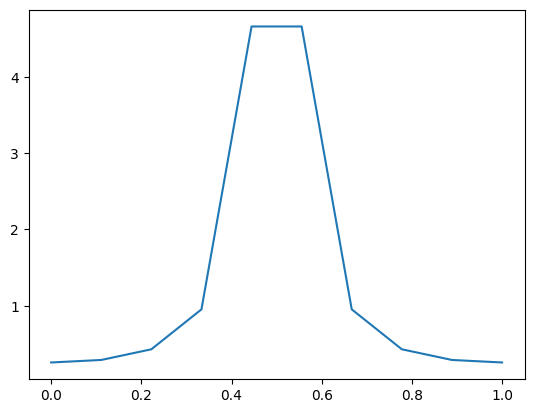

In [24]:
import src.diffusion as diffusionModule
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(diffusionModule)
x = np.linspace(0,1 ,10)
plt.plot(x , diffusionModule.oscillation(x))

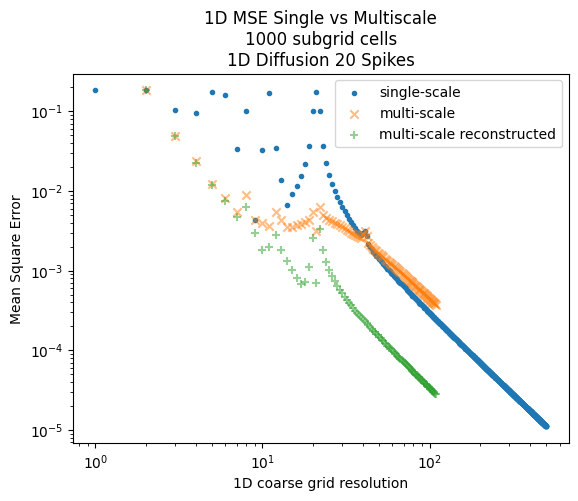

In [30]:
import src.fvsolver as fvModule
reload(fvModule)
diffusionFunction = lambda x: diffusionModule.oscillation(x,eps=1/20)


fineX = np.linspace(0, 1, 10000)
solver = fvModule.FVSolver(10000, diffusionFunction, (0,1))
solver.set_boundary()
solver.assemble_matrix()
referenceSolution = solver.solve()

# plt.plot(fineX , referenceSolution)

gridCoarseLevels = np.arange(1, 500, 1)
gridCoarseLevelsMulti = np.arange(2, 110, 1)

singleScaleErrorLevels = []
multiScaleErrorLevels = []
multiScaleReconstructErrorLevels = []


for coarseLevel in gridCoarseLevels:
    # solve single scale
    coarseX = np.linspace(0,1 ,coarseLevel)
    solver = fvModule.FVSolver(coarseLevel, diffusionFunction, (0,1))
    solver.set_boundary()
    solver.assemble_matrix()
    coarseSolution = solver.solve()
    interpolatedCoarseSolution = np.interp(fineX, coarseX, coarseSolution)
    error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
    singleScaleErrorLevels.append(error)

for coarseLevel in gridCoarseLevelsMulti:
    #solve multi scale
    coarseX = np.linspace(0,1 ,coarseLevel)
    solver = fvModule.FVSolver(coarseLevel, diffusionFunction, (0,1))
    solver.set_boundary()
    mb = solver.set_multiscale_transmissions(1000)
    solver.assemble_matrix()
    coarseSolution = solver.solve()
    interpolatedCoarseSolution = np.interp(fineX, coarseX, coarseSolution)
    error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
    multiScaleErrorLevels.append(error)


    reconstructedSolution = solver.reconstruct_multiscale()
    reconstructedX = np.linspace(0,1,len(solver.micro_basis))
    interpolatedCoarseSolution = np.interp(fineX, reconstructedX, solver.reconstruction)
    error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
    multiScaleReconstructErrorLevels.append(error)


plt.scatter(gridCoarseLevels, singleScaleErrorLevels, marker=".", label="single-scale")
plt.scatter(gridCoarseLevelsMulti, multiScaleErrorLevels, marker="x", alpha=0.5, label="multi-scale")
plt.scatter(gridCoarseLevelsMulti, multiScaleReconstructErrorLevels, marker="+", alpha=0.5, label="multi-scale reconstructed")

plt.title("1D MSE Single vs Multiscale\n1000 subgrid cells\n1D Diffusion 20 Spikes")

plt.xlabel("1D coarse grid resolution")
plt.ylabel("Mean Square Error")
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend()



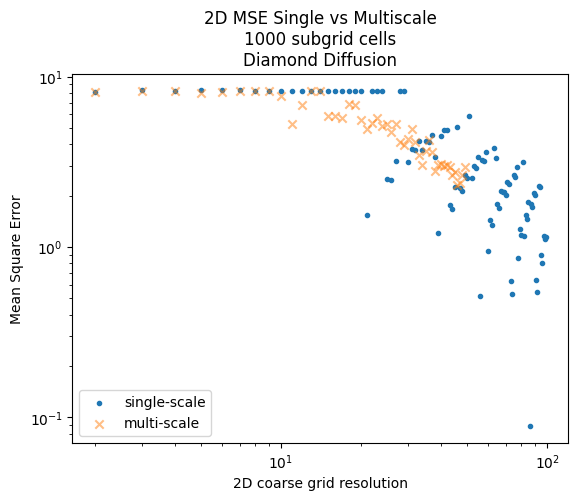

In [ ]:
import src.fvsolver as fvModule
from scipy.interpolate import LinearNDInterpolator
reload(fvModule)


diffusionFunctions = [lambda x,y: diffusionModule.osc2D_line(x,y,eps=1/10),
                        lambda x,y: diffusionModule.osc2D_point(x,y,eps=1/10),
                        lambda x,y: diffusionModule.box(x,y),
                        lambda x,y: diffusionModule.circle(x,y),
                        lambda x,y: diffusionModule.rhombus(x,y)]
subtitles = ["Line Diffusion 10 Spikes","Point Diffusion 10 Spikes","Box Diffusion","Circle Diffusion","Diamond Diffusion"]
basePath = "errorImages/mse_2d_"
endingPath = ".png"
paths = ["line","point","box","cirlce","line"]

for i in range(5):
    diffusionFunction = diffusionFunctions[i]

    fineN = 1000
    fineX = np.linspace(0, 1, fineN)
    fineY = np.linspace(0, 1, fineN)
    fineXX, fineYY = np.meshgrid(fineX, fineY)
    finePoints = np.column_stack([fineXX.ravel(), fineYY.ravel()])
    solver = fvModule.FVSolver2D(fineN, fineN, diffusionFunction)
    solver.set_boundary()
    solver.assemble_matrix()
    referenceSolution = solver.solve()

    # plt.plot(fineX , referenceSolution)

    gridCoarseLevels = np.arange(2, 100, 1)
    gridCoarseLevelsMulti = np.arange(2, 50, 1)

    singleScaleErrorLevels = []
    multiScaleErrorLevels = []
    multiScaleReconstructErrorLevels = []


    for coarseLevel in gridCoarseLevels:
        # solve single scale
        coarseX = np.linspace(0, 1, coarseLevel)
        coarseY = np.linspace(0, 1, coarseLevel)
        coarseXX, coarseYY = np.meshgrid(coarseX, coarseY)
        coarsePoints = np.column_stack([coarseXX.ravel(), coarseYY.ravel()])

        solver = fvModule.FVSolver2D(coarseLevel,coarseLevel, diffusionFunction)
        solver.set_boundary()
        solver.assemble_matrix()
        coarseSolution = solver.solve()

        interpolator = LinearNDInterpolator(coarsePoints, coarseSolution.ravel())
        interpolatedCoarseSolution = interpolator(finePoints).reshape(fineXX.shape)

        error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
        singleScaleErrorLevels.append(error)

    for coarseLevel in gridCoarseLevelsMulti:
        #solve multi scale
        coarseX = np.linspace(0, 1, coarseLevel)
        coarseY = np.linspace(0, 1, coarseLevel)
        coarseXX, coarseYY = np.meshgrid(coarseX, coarseY)
        coarsePoints = np.column_stack([coarseXX.ravel(), coarseYY.ravel()])

        solver = fvModule.FVSolver2D(coarseLevel,coarseLevel, diffusionFunction)
        solver.set_boundary()
        mb = solver.set_multiscale_transmissions(1000)
        solver.assemble_matrix()
        coarseSolution = solver.solve()

        interpolator = LinearNDInterpolator(coarsePoints, coarseSolution.ravel())
        interpolatedCoarseSolution = interpolator(finePoints).reshape(fineXX.shape)

        error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
        multiScaleErrorLevels.append(error)


        # reconstructedSolution = solver.reconstruct_multiscale()
        # reconstructedN = len(solver.micro_basis)
        # reconstructedX = np.linspace(0, 1, reconstructedN)
        # reconstructedY = np.linspace(0, 1, reconstructedN)
        # rcXX, rcYY = np.meshgrid(reconstructedX, reconstructedY)
        # reconstructedPoints = np.column_stack([rcXX.ravel(), rcYY.ravel()])
        # # interpolatedCoarseSolution = np.interp(fineX, reconstructedX, solver.reconstruction)
        
        # interpolator = LinearNDInterpolator(reconstructedPoints, reconstructedSolution.ravel())
        # interpolatedCoarseSolution = interpolator(finePoints).reshape(fineXX.shape)

        # error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
        # multiScaleReconstructErrorLevels.append(error)


    plt.scatter(gridCoarseLevels, singleScaleErrorLevels, marker=".", label="single-scale")
    plt.scatter(gridCoarseLevelsMulti, multiScaleErrorLevels, marker="x", alpha=0.5, label="multi-scale")
    # plt.scatter(gridCoarseLevelsMulti, multiScaleReconstructErrorLevels, marker="+", alpha=0.5, label="multiscale reconstructed")

    plt.title(f"2D MSE Single vs Multiscale\n1000 subgrid cells\n{subtitles[i]}")

    plt.xlabel("2D coarse grid resolution")
    plt.ylabel("Mean Square Error")
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.legend()
    plt.savefig(basePath+paths[i]+endingPath)
